# Recreating Bollinger-Bands Trading Strategy

In [ ]:
import datetime  # For datetime objects
import pandas as pd  # For data manipulation

import yfinance as yf # for finance data

# visualization
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display

import backtrader as bt

## Getting Data

In [127]:
MDB_data = yf.download('MDB', start='2020-1-1', end='2022-10-07')
MDB_data.columns = MDB_data.columns.droplevel('Ticker')
MDB_data

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,134.330002,134.669998,126.080002,130.179993,1166900
2020-01-03,135.289993,136.220001,131.759995,132.429993,598300
2020-01-06,140.500000,140.889999,132.705002,132.880005,1254600
2020-01-07,138.860001,142.610001,138.250000,140.500000,672000
2020-01-08,140.270004,141.639999,136.229996,138.899994,978800
...,...,...,...,...,...
2022-09-30,198.559998,210.500000,194.425003,196.399994,2699100
2022-10-03,194.070007,200.929993,185.509995,199.009995,3301400
2022-10-04,203.309998,208.990005,200.429993,201.410004,3276300


In [128]:
# cryptocurrency data
from binance.client import Client
import pandas as pd

client = Client()

def getdata(symbol, start, end):
    df = pd.DataFrame(client.get_historical_klines(symbol, Client.KLINE_INTERVAL_1DAY, start, end))
    df = df.iloc[:, :6]
    df.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
    df.set_index('Time', inplace=True)
    df.index = pd.to_datetime(df.index, unit='ms')
    df = df.astype(float)
    return df

BTC_data = getdata('BTCUSDT', '2020-1-1', '2022-10-07')
BTC_data

,Open,High,Low,Close,Volume
Time,,,,,
2020-01-01,7195.24,7255.00,7175.15,7200.85,16792.388165
2020-01-02,7200.77,7212.50,6924.74,6965.71,31951.483932
2020-01-03,6965.49,7405.00,6871.04,7344.96,68428.500451
2020-01-04,7345.00,7404.00,7272.21,7354.11,29987.974977
2020-01-05,7354.19,7495.00,7318.00,7358.75,38331.085604
...,...,...,...,...,...
2022-10-03,19057.74,19719.10,18959.68,19629.08,293585.752120
2022-10-04,19629.08,20475.00,19490.60,20337.82,327012.001270
2022-10-05,20337.82,20365.60,19730.00,20158.26,312239.752240


## Creating Strategy

In [ ]:
# Create a Stratey
class BollingerBands(bt.Strategy):

    # simply prints
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    # define parameters
    def __init__(self):
        # close price
        self.dataclose = self.datas[0].close
        # open price
        self.dataopen = self.datas[0].open
        # track pending orders
        self.order = None

        # 200 day sma
        self.sma = bt.ind.SMA(period=200)

        # closing 2.5 std below 20 day bollinger band
        # **this is the 20 day SMA plus/minus 2.5 standard deviations of that SMA**
        self.boll = bt.ind.BollingerBands(period=20, devfactor=2.5)

        # exit when 2 day RSI is above 50
        # **2 day RSI above 50 means when gains surpass losses**
        self.rsi = bt.ind.RSI(period=2, safediv=True)



    # tracking when the order is executed
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None



    # the strategy logic
    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:
            if (self.dataclose[0] < self.sma and # if it's less than SMA
                self.dataclose[0] < self.boll.lines.bot): # and if it's less than the lower bollinger band

                # 97 % of current close price
                price = self.dataclose[0] * 0.97

                self.log('BUY CREATE, %.2f' % price)

                # place a 3% buy limit order (97% of current close)
                self.order = self.buy(
                    exectype=bt.Order.Limit,
                    price=price
                )

        # we are in the market and might sell
        else:

            # if been in market for 10 days or RSI is above 50
            if len(self) >= (self.bar_executed + 10) or (self.rsi > 50):

                midprice = (self.dataclose[0] + self.dataopen[0]) / 2

                # simple market sell order at midprice
                self.log('SELL CREATE, %.2f' % midprice)


                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell(
                    exectype=bt.Order.Limit,
                    price=midprice
                )

## Backtesting for two assets

Starting Portfolio Value: 1000.00
2020-10-15, Close, 269.87
2020-10-16, Close, 267.30
2020-10-19, Close, 265.24
2020-10-20, Close, 256.68
2020-10-21, Close, 248.84
2020-10-22, Close, 245.75
2020-10-23, Close, 248.00
2020-10-26, Close, 240.10
2020-10-27, Close, 244.01
2020-10-28, Close, 240.04
2020-10-29, Close, 235.69
2020-10-30, Close, 228.47
2020-11-02, Close, 224.18
2020-11-03, Close, 226.97
2020-11-04, Close, 244.67
2020-11-05, Close, 253.15
2020-11-06, Close, 252.40
2020-11-09, Close, 239.89
2020-11-10, Close, 230.06
2020-11-11, Close, 245.09
2020-11-12, Close, 251.02
2020-11-13, Close, 246.86
2020-11-16, Close, 242.94
2020-11-17, Close, 248.34
2020-11-18, Close, 247.34
2020-11-19, Close, 255.11
2020-11-20, Close, 264.28
2020-11-23, Close, 265.35
2020-11-24, Close, 264.60
2020-11-25, Close, 265.40
2020-11-27, Close, 270.02
2020-11-30, Close, 287.31
2020-12-01, Close, 275.30
2020-12-02, Close, 267.91
2020-12-03, Close, 272.01
2020-12-04, Close, 277.63
2020-12-07, Close, 280.46
2020

<IPython.core.display.Javascript object>

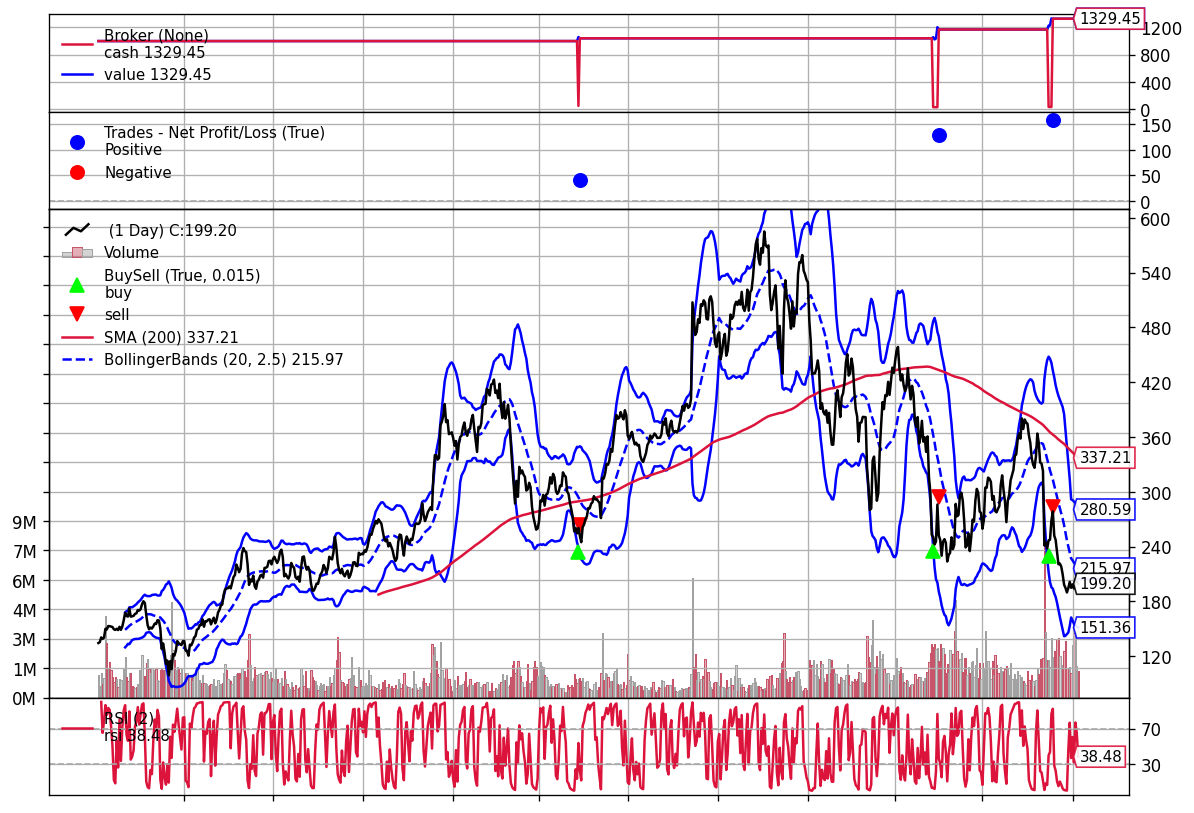

In [ ]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(BollingerBands)

# Create a Data Feed
MDB_data = bt.feeds.PandasData(dataname=MDB_data)

# Add the Data Feed to Cerebro
cerebro.adddata(MDB_data)

# Set our desired cash start
cerebro.broker.setcash(1000)

# commissions
cerebro.broker.setcommission(commission=0.005)

# size of trades
cerebro.addsizer(bt.sizers.PercentSizer, percents=100)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Plot the result
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['figure.dpi'] = 120
figs = cerebro.plot()
for figlist in figs:
    for f in figlist:
        display(f)

Starting Portfolio Value: 1000.00
2020-07-18, Close, 9170.28
2020-07-19, Close, 9208.99
2020-07-20, Close, 9160.78
2020-07-21, Close, 9390.00
2020-07-22, Close, 9518.16
2020-07-23, Close, 9603.27
2020-07-24, Close, 9537.80
2020-07-25, Close, 9700.42
2020-07-26, Close, 9931.54
2020-07-27, Close, 11029.96
2020-07-28, Close, 10906.27
2020-07-29, Close, 11100.53
2020-07-30, Close, 11099.61
2020-07-31, Close, 11335.46
2020-08-01, Close, 11801.17
2020-08-02, Close, 11071.35
2020-08-03, Close, 11219.81
2020-08-04, Close, 11191.97
2020-08-05, Close, 11744.91
2020-08-06, Close, 11762.46
2020-08-07, Close, 11594.23
2020-08-08, Close, 11761.41
2020-08-09, Close, 11681.68
2020-08-10, Close, 11892.92
2020-08-11, Close, 11392.08
2020-08-12, Close, 11564.33
2020-08-13, Close, 11780.00
2020-08-14, Close, 11760.54
2020-08-15, Close, 11852.40
2020-08-16, Close, 11911.00
2020-08-17, Close, 12281.13
2020-08-18, Close, 11945.01
2020-08-19, Close, 11754.59
2020-08-20, Close, 11853.55
2020-08-21, Close, 1153

<IPython.core.display.Javascript object>

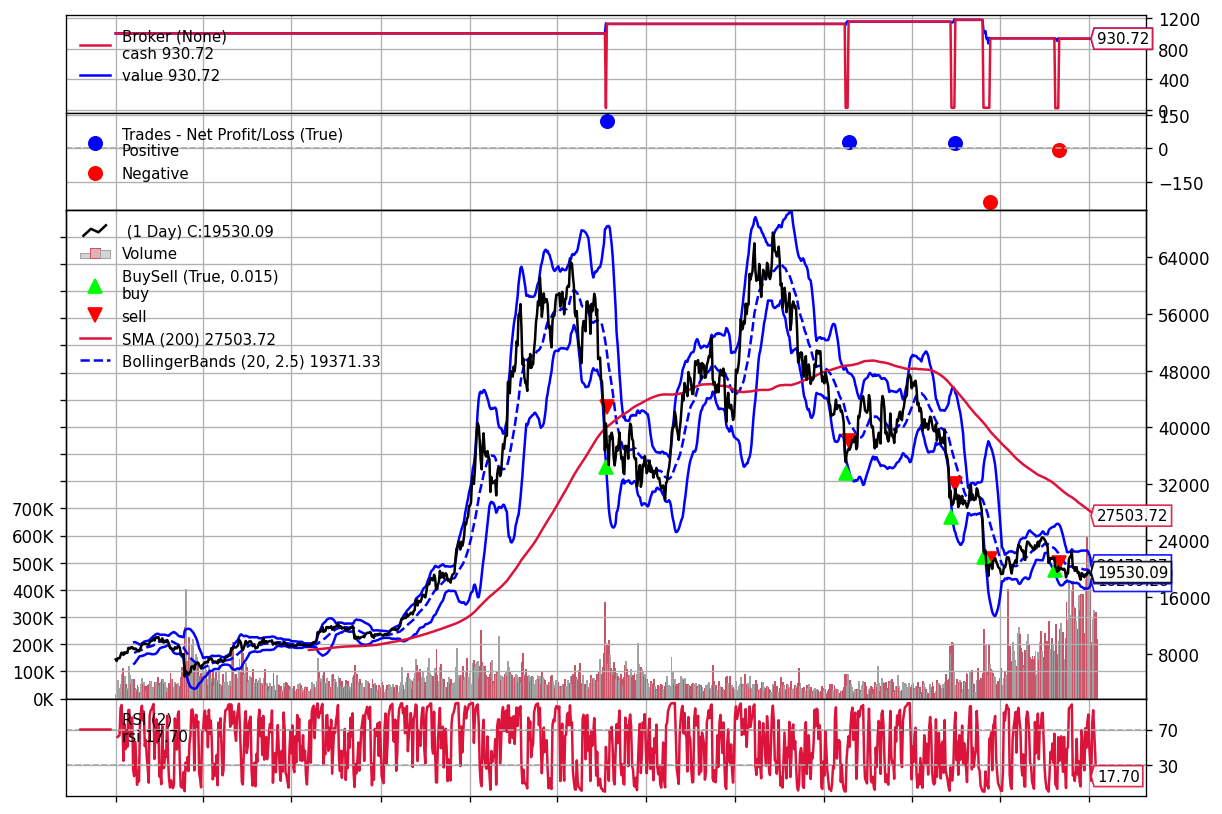

In [ ]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(BollingerBands)

# Create a Data Feed
BTC_data = bt.feeds.PandasData(dataname=BTC_data)

# Add the Data Feed to Cerebro
cerebro.adddata(BTC_data)

# Set our desired cash start
cerebro.broker.setcash(1000)

# commissions
cerebro.broker.setcommission(commission=0.005)

# size of trades
cerebro.addsizer(bt.sizers.PercentSizer, percents=100)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Plot the result
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['figure.dpi'] = 120
figs = cerebro.plot()
for figlist in figs:
    for f in figlist:
        display(f)